In [1]:
import numpy as np 
import pandas as pd 
import yfinance as yf 
import datetime as dt 
from _measurements import * 
from _weight_optimization import *
from _time_varying_optimization import *
from _regime_detection import *
import seaborn as sns 
import pytse_client as tse 
import matplotlib.pyplot as plt
import os
sns.set_theme()

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# returns = pd.DataFrame()
# for symb in os.listdir("tickers_data"):
#     data = pd.read_csv(os.path.join("tickers_data", symb))
#     close = data["close"].pct_change()
#     returns[symb.removesuffix(".csv")] = close
    
# returns.dropna(inplace=True)

In [4]:
# List of symbols
symbols = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'JNJ', 'WMT', 'KO', 'BAC', 'ADBE', 'CSCO', 'MCD', 'NFLX', 'NKE', 'PUM.DE',
    'PM', 'IBM', 'GE'
]

# Download historical data for the symbols
data = yf.download(symbols, start='2007-01-01', end='2023-08-07')["Close"]

# Print the first few rows of the data
data.dropna(inplace=True)
returns = data.pct_change().dropna()
returns

[*********************100%***********************]  18 of 18 completed


,AAPL,ADBE,AMZN,BAC,CSCO,GE,GOOGL,IBM,JNJ,KO,MCD,MSFT,NFLX,NKE,NVDA,PM,PUM.DE,WMT
Date,,,,,,,,,,,,,,,,,,
2008-03-18,0.048055,0.035401,0.077709,0.082592,0.053108,0.052724,0.045943,0.024751,0.019831,0.029815,0.010501,0.039576,0.060928,0.040668,0.062150,0.004252,0.037614,0.020621
2008-03-19,-0.023716,0.090025,-0.021339,-0.009504,-0.043393,-0.015219,-0.016304,-0.012414,-0.006584,0.009258,-0.021696,-0.027192,-0.003714,0.002595,-0.069056,0.010081,0.002574,-0.003923
2008-03-20,0.027763,-0.008633,0.043038,0.085581,0.012260,0.053386,0.003588,0.011886,0.007707,0.018012,0.014163,0.019567,0.039289,0.087983,0.048698,-0.018962,0.016431,0.048247
2008-03-25,0.057852,0.060668,0.027053,-0.021261,0.039564,-0.005868,0.039742,-0.003042,-0.012695,0.006062,0.032709,-0.001371,0.024282,0.016352,0.097192,0.052899,0.039825,-0.003382
2008-03-26,0.028940,0.018062,-0.018225,-0.027581,-0.037670,-0.003756,0.016438,-0.008985,0.002324,-0.004234,-0.010676,-0.019904,0.019935,-0.030715,-0.031988,-0.028019,-0.017207,-0.002827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,0.003166,0.032711,0.011119,0.003135,-0.000960,-0.001311,0.001056,0.005089,-0.039833,-0.008803,-0.002823,-0.007241,0.030978,0.016295,-0.000449,-0.001402,-0.000976,-0.000313
2023-08-01,-0.004276,0.005365,-0.014886,-0.011875,0.011914,-0.008929,-0.008816,-0.005895,0.008118,-0.002584,-0.007265,0.001250,-0.000797,-0.008968,-0.004751,-0.014741,-0.013021,-0.004692
2023-08-02,-0.015490,-0.034238,-0.026426,-0.013599,-0.001519,-0.011040,-0.024097,0.005861,0.006039,0.003076,-0.004982,-0.026283,-0.020336,-0.017276,-0.048122,-0.003155,-0.001979,0.000691


In [ ]:
methods_mu = ["historical", "EWMA", "ledoit", "oracle", "shrunk", "mincovdet"]
methods_cov = ["historical", "EWMA", "ledoit", "oracle", "shrunk", "mincovdet"]
objectives = ["min_risk", "max_sharpe", "max_return", "max_utility"]

final_results = []

for i in range(len(methods_mu)):
    mu = methods_mu[i]
    cov = methods_cov[i]
    for objective in objectives:
        params = {
            "train_low": 30, 
            "train_high": 33, 
            "test_low": 30, 
            "test_high": 33, 
            "step": 1,
            "method_mu": mu, 
            "method_cov": cov, 
            "objective": objective
            }
        
        int_opt = RollingTimeOptimization(returns, params)
        results = int_opt()
        final_results.append(results)

In [ ]:
np.array(final_results).shape

In [20]:
data = (returns + 1).cumprod()
data = data["AAPL"]
rg = RegimeDetection(data)
betas = rg.trend_filtering(returns*100, lambda_value=5)
tr = rg.regime_switch_series(betas)["AAPL"]
apple = pd.concat([data, tr], axis=1)
apple.columns = ["Price", "Trend"]
apple

,Price,Trend
Date,,
2008-03-18,1.048055,1.0
2008-03-19,1.023199,1.0
2008-03-20,1.051606,1.0
2008-03-25,1.112444,1.0
2008-03-26,1.144638,1.0
...,...,...
2023-07-31,43.404090,1.0
2023-08-01,43.218500,-1.0
2023-08-02,42.549045,-1.0


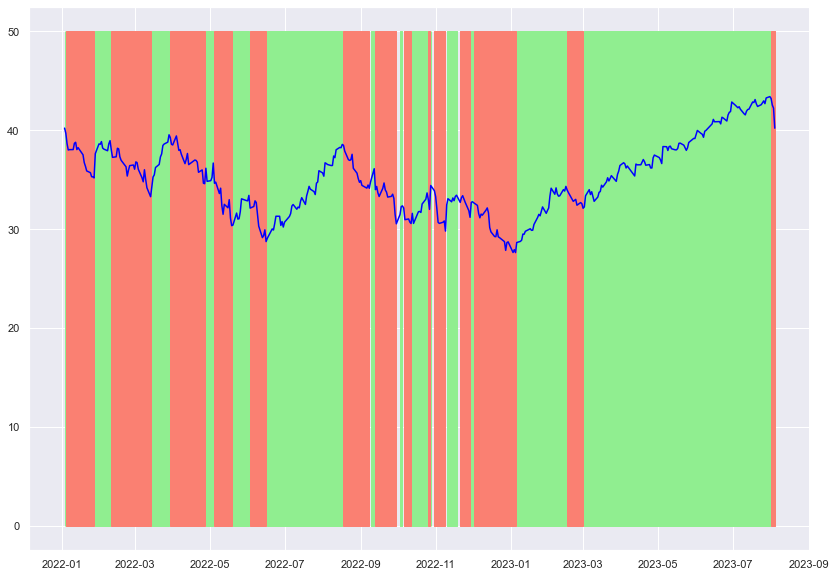

In [21]:
# Plot the stock price app
app = apple.loc[apple.index > "2022"]
plt.figure(figsize=(14, 10))
plt.plot(app.index, app['Price'], label='Stock Price', color='blue')

plt.fill_between(app["Price"].index, y1=0, y2=50,
                             where=app["Trend"] > 0, color="lightgreen", label="bullish")
plt.fill_between(app["Price"].index, y1=0, y2=50,
                    where=app["Trend"] < 0, color="salmon", label="bearish")